# Embryoid Body Dataset EMD results (Table 3in TrajectoryNet paper)


In [88]:
# Uncomment if Needed
# !pip install --user magic-impute
# !pip install --user phate
# !pip install --user scprep

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from TrajectoryNet.dataset import EBData
from TrajectoryNet.optimal_transport.emd import earth_mover_distance, interpolate_with_ot

from gp_sinkhorn.SDE_solver import solve_sde_RK
from gp_sinkhorn.MLE_drift import *
from gp_sinkhorn.utils import plot_trajectories_2

import torch

from celluloid import Camera
from IPython.display import HTML
import math

In [90]:
# Loading the dataset from the TrajectoryNet repo file eb_velocity_v5.npz, which we added to our repo

ds = EBData('pcs', max_dim=5)

In [6]:
ds.get_data().shape

(16819, 5)

<AxesSubplot:>

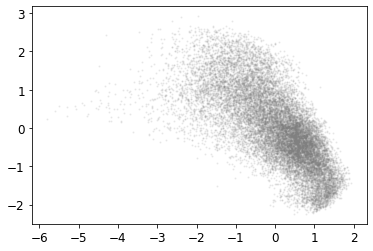

In [7]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(ds.get_data(), c='Gray', alpha=0.1, ax=ax)

### Extracting Start and Endpoint Frames

Extracting the frames to fit GP_IPFP on.

In [122]:
frame_0_start, frame_0_end = np.where(ds.labels == 0)[0][0], np.where(ds.labels == 0)[0][-1]
frame_4_start, frame_4_end = np.where(ds.labels == 4)[0][0], np.where(ds.labels == 4)[0][-1]


frame_2_start, frame_2_end = np.where(ds.labels == 2)[0][0], np.where(ds.labels == 2)[0][-1]

frame_1_start, frame_1_end = np.where(ds.labels == 1)[0][0], np.where(ds.labels == 1)[0][-1]


frame_3_start, frame_3_end = np.where(ds.labels == 3)[0][0], np.where(ds.labels == 3)[0][-1]

X_mid_f = ds.get_data()[frame_3_start:frame_3_end+1]

In [15]:
earth_mover_distance(X_mid_f,X_mid_f)

0.0

In [21]:
X_0_f = ds.get_data()[frame_0_start:frame_0_end+1]
X_1_f = ds.get_data()[frame_4_start:]


In [22]:
many_results = pd.read_pickle('../data/result_final.pkl')
result_final_epoch = many_results[-1]

time_forward, zs_forward, time_backward, zs_backward = result_final_epoch

zs_forward_ = zs_forward[:,:,:-1]
zs_backward_ = zs_backward[:,:,:-1]

In [23]:
zs_backward_.shape

torch.Size([3331, 21, 5])

In [132]:

place = 0.75
tpi_f = int(math.floor(zs_forward_.shape[1] * place))
tpi_b = int(math.floor(zs_backward_.shape[1] *(1-place) ))

emd_f = earth_mover_distance(zs_forward_[:,tpi_f,:], X_mid_f)
emd_b = earth_mover_distance(zs_backward_[:,tpi_b,:], X_mid_f)

In [133]:
emd_f, emd_b

(1.2992493659711397, 1.334800448598187)

In [91]:
from scipy.spatial.distance import cdist

M = M = ot.dist(X_0_f, X_1_f)
M /= M.max()

In [92]:
b

array([0.00030012, 0.00030012, 0.00030012, ..., 0.00030012, 0.00030012,
       0.00030012])

In [93]:
n, m = X_0_f.shape[0], X_1_f.shape[0]

a, b = np.ones(n,)/n, np.ones(m,)/m

In [94]:
import ot


Wd = ot.emd(a,b ,M, numItermax=1e7) # exact linear program


In [95]:
Wd

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

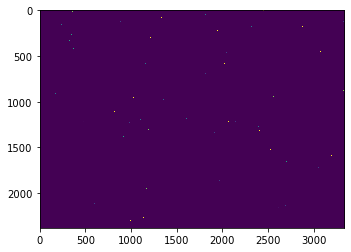

In [96]:
plt.imshow(Wd, interpolation='nearest')

In [97]:
Wd_reg = ot.sinkhorn(a,b ,M, 1.0) 

In [98]:
(Wd_reg ).max()

1.8226312415516966e-07

In [99]:
Wd_reg.shape[0] * Wd_reg.shape[1]

7933492

In [104]:

import scipy
import numpy
def interpolate_with_ot(p0, p1, tmap, interp_frac, size):
    """
    Interpolate between p0 and p1 at fraction t_interpolate knowing a transport map from p0 to p1
    Parameters
    ----------
    p0 : 2-D array
        The genes of each cell in the source population
    p1 : 2-D array
        The genes of each cell in the destination population
    tmap : 2-D array
        A transport map from p0 to p1
    t_interpolate : float
        The fraction at which to interpolate
    size : int
        The number of cells in the interpolated population
    Returns
    -------
    p05 : 2-D array
        An interpolated population of 'size' cells
    """
    p0 = p0.toarray() if scipy.sparse.isspmatrix(p0) else p0
    p1 = p1.toarray() if scipy.sparse.isspmatrix(p1) else p1
    p0 = np.asarray(p0, dtype=np.float64)
    p1 = np.asarray(p1, dtype=np.float64)
    tmap = np.asarray(tmap, dtype=np.float64)
    if p0.shape[1] != p1.shape[1]:
        raise ValueError("Unable to interpolate. Number of genes do not match")
    if p0.shape[0] != tmap.shape[0] or p1.shape[0] != tmap.shape[1]:
        raise ValueError(
            "Unable to interpolate. Tmap size is {}, expected {}".format(
                tmap.shape, (len(p0), len(p1))
            )
        )
    I = len(p0)
    J = len(p1)
    # Assume growth is exponential and retrieve growth rate at t_interpolate
    # If all sums are the same then this does not change anything
    # This only matters if sum is not the same for all rows
    p = tmap# / np.power(tmap.sum(axis=0), 1.0 - interp_frac)
    p = p.flatten(order="C")
    p = p / p.sum()
    choices = np.random.choice(I * J, p=p, size=size)
    return np.asarray(
        [p0[i // J] * (1 - interp_frac) + p1[i % J] * interp_frac for i in choices],
        dtype=np.float64,
    )

In [137]:
pint = interpolate_with_ot(X_0_f, X_1_f, Wd, 0.75, size=X_0_f.shape[0])

In [138]:
earth_mover_distance(pint, X_mid_f)

1.2058450075345648

In [84]:
Wdrnd = np.random.choice([0, 1],Wd.shape)

In [107]:
pint_rand = interpolate_with_ot(X_0_f, X_1_f, Wdrnd, 0.5, size=X_0_f.shape[0])

In [108]:
earth_mover_distance(pint_rand, X_mid_f)

1.5983824167854634